In [1]:
# 데이터분야 구직정보를 크롤링하여 트랜드와 수요 분석

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [3]:
from urllib.request import urlopen
import pandas as pd
import bs4

In [4]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By # 셀레니움 4.0부터 포함된 객체(모듈)

from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

In [5]:
# webdriver 객체 생성
chrome_options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

In [6]:
# 잡코리아 페이지 접속
url = 'https://www.jobkorea.co.kr/recruit/joblist?menucode=duty'

In [7]:
import time
# XPATH 이용
dev_xpath = '//*[@id="devSearchForm"]/div[2]/div/div[1]/dl[1]/dd[2]/div[2]/dl[1]/dd/div[1]/ul/li[6]/label/span/span'
DE_xpath = '//*[@id="duty_step2_10031_ly"]/li[8]/label/span/span' # 데이터엔지니어 xpath
DS_xpath = '//*[@id="duty_step2_10031_ly"]/li[9]/label/span/span' # 데이터사이언스 xpath
ML_xpath = '//*[@id="duty_step2_10031_ly"]/li[14]/label/span/span' # 머신러닝 xpath
region_xpath = '//*[@id="devSearchForm"]/div[2]/div/div[1]/dl[2]/dt/p'
seoul_xpath = '//*[@id="devSearchForm"]/div[2]/div/div[1]/dl[2]/dd[2]/div[2]/dl[1]/dd/div[1]/ul/li[1]/label/span/span'  # 서울 xpath
ok_xpath = '//*[@id="dev-btn-search"]/span'


In [8]:
# 채용 정보 크롤링 함수
def job_info(driver, section):
    title_name_list = [list.text for list in driver.find_elements(By.CSS_SELECTOR, '#dev-gi-list .devloopArea a.link.normalLog')]
    company_name = [name for idx, name in enumerate(title_name_list) if idx % 2 == 1] # 회사 이름 추출
    title = [title for idx, title in enumerate(title_name_list) if idx % 2 == 0] # 공고 제목 추출
    ect_list = [ect.text.split() for ect in driver.find_elements(By.CSS_SELECTOR, '#dev-gi-list .devloopArea p.etc')]
    # ect 분류
    need_level = [] # 경력
    need_grade = [] # 학력
    region = [] # 지역
    employ_type = [] # 고용형태
    pay = [] # 연봉
    rank = [] # 직급

    # ect_list 분류하기
    for ects in ect_list:
        ects = [ect for ect in ects if ect != '외' and ect != '서울']
        # print(ects)
        if len(ects) > 3:
            need_level.append(ects[0])
            need_grade.append(ects[1])
            region.append(ects[2])
            employ_type.append(ects[3])
            if len(ects) == 5:
                if ('만원' in ects[4]) or ('원(' in ects[4]):
                    pay.append(ects[4])
                    rank.append(None)
                else:
                    pay.append(None)
                    rank.append(ects[4])
            
            elif len(ects) == 6: 
                for ect in ects[4:]:
                    if ('만원' in ect) or ('원(' in ect):
                        pay.append(ect)
                    else:
                        rank.append(ect)
            else:
                pay.append(None)
                rank.append(None)
        elif len(ects) > 2:
            need_level.append(ects[0])
            need_grade.append(ects[1])
            region.append(ects[2])
            employ_type.append(None)
            pay.append(None)
            rank.append(None)
            
        else:
            need_level.append(ects[0])
            need_grade.append(None)
            region.append(ects[1])
            employ_type.append(None)
            pay.append(None)
            rank.append(None)

    # print(ect_list)
    print(len(title), len(company_name), len(need_level), len(need_grade), len(region), len(employ_type), len(rank), len(pay)) 
    print(employ_type, rank, pay)
    return {'title':title,
            'company_name':company_name,
            'need_level':need_level,
            'need_grade':need_grade,
            'region':region,
            'employ_type':employ_type,
            'rank':rank,
            'pay':pay,
            'section':section}

In [9]:
#데이터프레임 생성
job_df = pd.DataFrame({'title':[],
                        'company_name':[],
                        'need_level':[],
                        'need_grade':[],
                        'region':[],
                        'employ_type':[],
                        'rank':[],
                        'pay':[],
                        'section':[]})
      

In [10]:
# 데이터 엔지니어 추출
driver.get(url)

driver.find_element(By.XPATH, dev_xpath).click()
time.sleep(1)
driver.find_element(By.XPATH, DE_xpath).click()
time.sleep(1)
driver.find_element(By.XPATH, region_xpath).click()
time.sleep(1)
driver.find_element(By.XPATH, seoul_xpath).click()
time.sleep(1)
driver.find_element(By.XPATH, ok_xpath).click()
time.sleep(1)

# 페이지 반복후 각 페이지에 함수 적용
try:
    idx = 2
    while True:
        page_xpath = f'//*[@id="dvGIPaging"]/div/ul/li[{idx}]/a'
        ##  함수로 크롤링
        df = pd.DataFrame(job_info(driver, 'DE'))
        job_df = pd.concat([job_df, df], axis=0, ignore_index=True)
        print(str(idx)+'page finish')
        if idx < 10:
            driver.find_element(By.XPATH, page_xpath).click() # 다음페이지 클릭
            time.sleep(1)
            idx = idx+1
        else:
            driver.find_element(By.XPATH, '//*[@id="dvGIPaging"]/div/p/a').click() # 다음 버튼 클릭
            time.sleep(1)
            idx = 2
except Exception as e:
    print('finish') # 더이상 누를 버튼이 없으면 finish

40 40 40 40 40 40 40 40
[None, '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '연수생/교육생', '연수생/교육생', '연수생/교육생', '연수생/교육생', '연수생/교육생', None, None, '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직'] [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '사원급', None, '사원급', None, None, None, None, '팀원'] [None, None, None, None, None, None, None, None, None, None, None, None, None, '4,000~8,000만원', None, None, None, None, None, None, None, '6,000~10,000만원', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
2page finish
40 40 40 40 40 40 40 40
[None, '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '

In [11]:
# 데이터 사이언티스트 추출
driver.get(url)

driver.find_element(By.XPATH, dev_xpath).click()
time.sleep(1)
driver.find_element(By.XPATH, DS_xpath).click()
time.sleep(1)
driver.find_element(By.XPATH, region_xpath).click()
time.sleep(1)
driver.find_element(By.XPATH, seoul_xpath).click()
time.sleep(1)
driver.find_element(By.XPATH, ok_xpath).click()
time.sleep(1)

# 페이지 반복후 각 페이지에 함수 적용
try:
    idx = 2
    while True:
        page_xpath = f'//*[@id="dvGIPaging"]/div/ul/li[{idx}]/a'
        ##  함수로 크롤링
        df = pd.DataFrame(job_info(driver, 'DS'))
        job_df = pd.concat([job_df, df], axis=0, ignore_index=True)
        print(str(idx)+'page finish')
        if idx < 10:
            driver.find_element(By.XPATH, page_xpath).click() # 다음페이지 클릭
            time.sleep(1)
            idx = idx+1
        else:
            driver.find_element(By.XPATH, '//*[@id="dvGIPaging"]/div/p/a').click() # 다음 버튼 클릭
            time.sleep(1)
            idx = 2
except Exception as e:
    print('finish') # 더이상 누를 버튼이 없으면 finish

40 40 40 40 40 40 40 40
[None, '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '연수생/교육생', '연수생/교육생', None, None, None, '정규직', '정규직', '정규직', '계약직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직'] [None, None, None, None, None, None, '주임~대리급', '주임~대리급', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '사원급', None, '팀원', None, '과장~차장급', '사원급', '팀원', '팀원', None, None, None, None, None, None, None, None, '사원급'] [None, None, None, None, None, None, None, None, None, None, None, '5,000~10,000만원', None, None, '3,400~9,000만원', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '3,000~10,000만원', None, None, None, None, None]
2page finish
40 40 40 40 40 40 40 40
[None, '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '연수

In [12]:
# 머신러닝 추출
driver.get(url)

driver.find_element(By.XPATH, dev_xpath).click()
time.sleep(1)
driver.find_element(By.XPATH, ML_xpath).click()
time.sleep(1)
driver.find_element(By.XPATH, region_xpath).click()
time.sleep(1)
driver.find_element(By.XPATH, seoul_xpath).click()
time.sleep(1)
driver.find_element(By.XPATH, ok_xpath).click()
time.sleep(1)

# 페이지 반복후 각 페이지에 함수 적용
try:
    idx = 2
    while True:
        page_xpath = f'//*[@id="dvGIPaging"]/div/ul/li[{idx}]/a'
        ##  함수로 크롤링
        df = pd.DataFrame(job_info(driver, 'ML'))
        job_df = pd.concat([job_df, df], axis=0, ignore_index=True)
        print(str(idx)+'page finish')
        if idx < 10:
            driver.find_element(By.XPATH, page_xpath).click() # 다음페이지 클릭
            time.sleep(1)
            idx = idx+1
        else:
            driver.find_element(By.XPATH, '//*[@id="dvGIPaging"]/div/p/a').click() # 다음 버튼 클릭
            time.sleep(1)
            idx = 2
except Exception as e:
    print('finish') # 더이상 누를 버튼이 없으면 finish

40 40 40 40 40 40 40 40
['정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직'] [None, '주임~대리급', None, None, '사원급', None, None, None, None, None, None, None, None, '주임~대리급', '주임~대리급', None, None, None, None, None, None, None, None, None, None, '주임~대리급', None, None, '주임~대리급', None, None, None, None, None, None, None, None, None, None, None] [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '4,000~10,000만원', None, None, '4,000~10,000만원', None, None, None, None, None, None, None, None, None, None, None]
2page finish
40 40 40 40 40 40 40 40
['연수생/교육생', '연수생/교육생', '연수생/교육생', None, '정규직', '정규직', '계약직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', '정규직', 

In [13]:
job_df

,title,company_name,need_level,need_grade,region,employ_type,rank,pay,section
0,캐롯손해보험㈜,부문별 경력직 대규모 채용,경력1년↑,학력무관,정규직,None,None,None,DE
1,우리에프아이에스㈜,2024년 경력사원 채용 공고,경력3년↑,학력무관,마포구,정규직,None,None,DE
2,㈜바이오컴,[AI 헬스케어] 개발/기획/마케팅/회계/변호사 인재영입,경력3년↑,학력무관,강서구,정규직,None,None,DE
3,한국유미코아배터리머티리얼즈 유한책임회사,한국유미코아 배터리머티리얼즈 하반기 각 부문별 채용,신입·경력,대졸↑,전지역,정규직,None,None,DE
4,㈜팬코,각 부문별 신입 및 경력사원 채용,신입·경력,학력무관,성동구,정규직,None,None,DE
...,...,...,...,...,...,...,...,...,...
670,애드인에듀,자율주행 인공지능 로봇분야 양성 교육생 모집,경력무관,학력무관,금천구,연수생/교육생,None,None,ML
671,알토비전,인공지능 학습용 데이터 수집 (의료 문서),경력무관,학력무관,강남구,프리랜서,팀원,"10,000원(건)",ML
672,㈜와이즈교육,"KT 인공지능 코딩강사 (평일오전 시급4만 ) 초중고 프리랜서 강사모집 (신입,경력)",경력무관,학력무관,강서구,프리랜서,사원급,"40,000원(시)",ML
673,㈜와이즈교육,[평일오전만] 재택/자유 와이즈교육 초중고 프리랜서 강사모집,경력무관,학력무관,강서구,프리랜서,사원급,"40,000원(시)",ML


In [14]:
job_df.to_csv('./crawl_data/job_info_1216.csv', index=0, encoding='utf-8-sig')

In [15]:
job_df = pd.read_csv('./crawl_data/job_info_1216.csv')

In [16]:
desire_job_df = pd.read_csv('./crawl_data/chat_members.csv')

In [17]:
desire_job_df

,grade,level,section,sub_section
0,학부,0,DS,DA
1,석사,0,ML,CV
2,석사,4,ML,NLP
3,학사,0,ML,NLP
4,석사,0,ML,AI
...,...,...,...,...
539,학사,0,DS,DA
540,학부,0,DS,DA
541,학사,1,ML,AI
542,석사,0,ML,AI


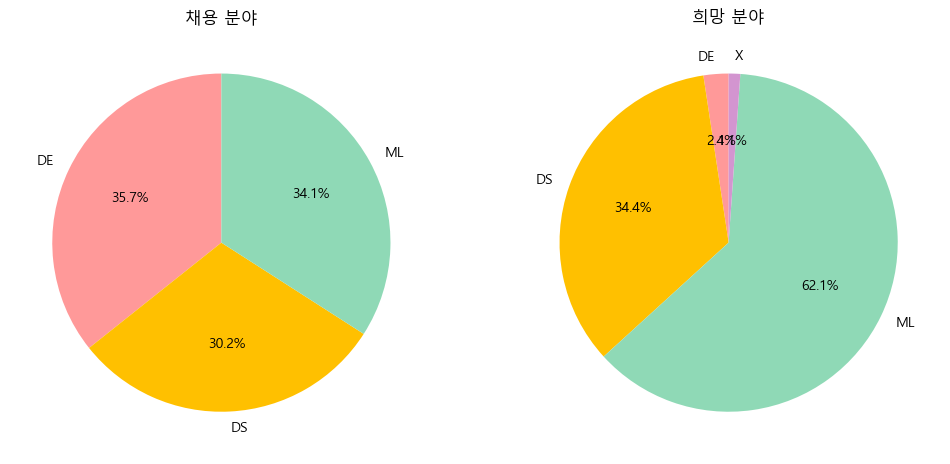

In [23]:
# 시각화
# 수요와 공급
import matplotlib.pyplot as plt
import matplotlib

# 한글 폰트
matplotlib.rc('font', family='Malgun Gothic')
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']

_ = fig, section = plt.subplots(1, 2, figsize=(12, 6))
_ = section[0].pie(job_df['section'].value_counts().sort_index(),
                   labels=job_df['section'].value_counts().sort_index().index,
                   autopct='%1.1f%%',
                   colors=colors,
                   startangle=90)
_ = section[0].set_title('채용 분야')

_ = section[1].pie(desire_job_df['section'].value_counts().sort_index(),
                   labels=desire_job_df['section'].value_counts().sort_index().index,
                   autopct='%1.1f%%',
                   colors=colors,
                   startangle=90)
_ = section[1].set_title('희망 분야')

_ = plt.show()

In [118]:
# 데이터 전처리
job_df_drop = job_df.drop_duplicates(subset=['title']) # 중복되는 공고는 삭제
job_df_drop = job_df_drop[~(job_df_drop['need_grade'].str.contains('구', na=False))] # 분류가 잘못된 데이터 삭제/단 Non값은 False로
job_df_drop

,title,company_name,need_level,need_grade,region,employ_type,rank,pay,section
0,캐롯손해보험㈜,부문별 경력직 대규모 채용,경력1년↑,학력무관,정규직,NaN,NaN,NaN,DE
1,우리에프아이에스㈜,2024년 경력사원 채용 공고,경력3년↑,학력무관,마포구,정규직,NaN,NaN,DE
2,㈜바이오컴,[AI 헬스케어] 개발/기획/마케팅/회계/변호사 인재영입,경력3년↑,학력무관,강서구,정규직,NaN,NaN,DE
3,한국유미코아배터리머티리얼즈 유한책임회사,한국유미코아 배터리머티리얼즈 하반기 각 부문별 채용,신입·경력,대졸↑,전지역,정규직,NaN,NaN,DE
4,㈜팬코,각 부문별 신입 및 경력사원 채용,신입·경력,학력무관,성동구,정규직,NaN,NaN,DE
...,...,...,...,...,...,...,...,...,...
659,㈜어썸좋은생각,[신입/경력]머신러닝 개발자 채용,경력무관,학력무관,강남구,계약직,사원급,"2,600~3,000만원",ML
661,㈜플랜바이테크놀로지스,[Planby Technologies 신입/경력] AI 개발자 모집,경력무관,대졸↑,강남구,정규직,NaN,"3,600~6,500만원",ML
662,㈜케이에스씨앤씨(KSC&C Inc.),[신입/경력] AI 기반 업무자동화(RPA) 개발자 채용 (UiPath 우대),신입·경력1년↑,초대졸↑,영등포구,정규직,사원급,NaN,ML
671,알토비전,인공지능 학습용 데이터 수집 (의료 문서),경력무관,학력무관,강남구,프리랜서,팀원,"10,000원(건)",ML


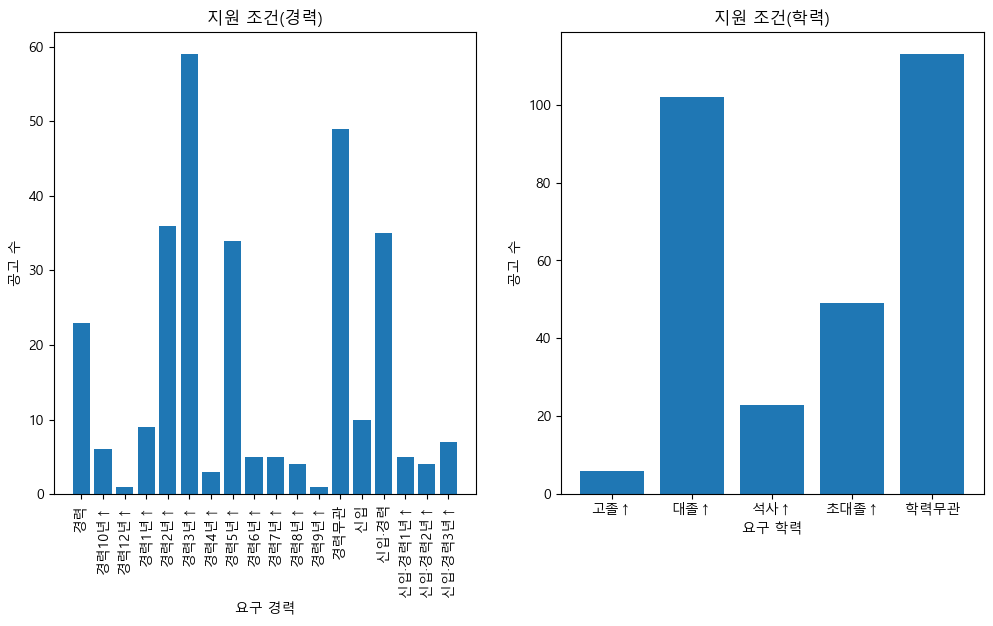

In [119]:
_ = fig, section = plt.subplots(1, 2, figsize=(12, 6))
_ = section[0].bar(job_df_drop['need_level'].value_counts().sort_index().index,
                   job_df_drop['need_level'].value_counts().sort_index())
_ = section[0].set_xlabel('요구 경력')
_ = section[0].set_ylabel('공고 수')
_ = section[0].set_title('지원 조건(경력)')
_ = section[0].tick_params(axis='x', rotation=90) # xlabel 90도 회전

_ = section[1].bar(job_df_drop['need_grade'].value_counts().sort_index().index,
                   job_df_drop['need_grade'].value_counts().sort_index())
_ = section[1].set_xlabel('요구 학력')
_ = section[1].set_ylabel('공고 수')
_ = section[1].set_title('지원 조건(학력)')

plt.show()

In [19]:
# !pip install wordcloud
from wordcloud import WordCloud

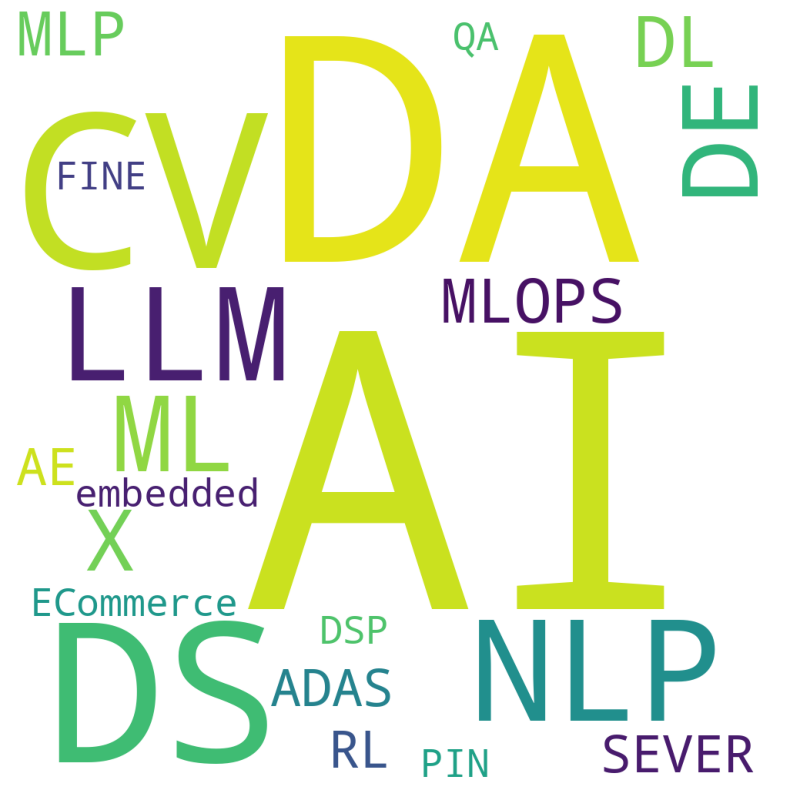

In [81]:
# 희망 분야 세부 분석
text = ' '.join(desire_job_df['sub_section'])

# WordCloud 생성
wordcloud = WordCloud(width=1000, height=1000, background_color='white').generate(text)

# 워드클라우드 시각화
_ = plt.figure(figsize=(15, 10))
_ = plt.imshow(wordcloud)
_ = plt.axis('off')  # 축 숨기기
plt.show()

In [73]:
desire_job_df_new = pd.DataFrame(desire_job_df[desire_job_df['level']==0].groupby(['sub_section'])['level'].count().sort_values())
desire_job_df_pro = pd.DataFrame(desire_job_df[desire_job_df['level']!=0].groupby(['sub_section'])['level'].count().sort_values())
# 신입 선호분야 데이터프레임
desire_job_df_new_drop = desire_job_df_new
desire_job_df_new_drop.loc['ect'] = desire_job_df_new_drop.iloc[:-7].sum()
desire_job_df_new_drop = desire_job_df_new_drop.iloc[-8:]
desire_job_df_new_drop
# 경력 선호분야 데이터프레임
desire_job_df_pro_drop = desire_job_df_pro
desire_job_df_pro_drop.loc['ect'] = desire_job_df_pro_drop.iloc[:-7].sum()
desire_job_df_pro_drop = desire_job_df_pro_drop.iloc[-8:]
desire_job_df_pro_drop

,level
sub_section,
ML,8
DE,9
NLP,15
DS,31
CV,43
DA,125
AI,183
ect,30


,level
sub_section,
MLOPS,3
NLP,4
LLM,8
CV,9
DS,11
DA,15
AI,41
ect,9


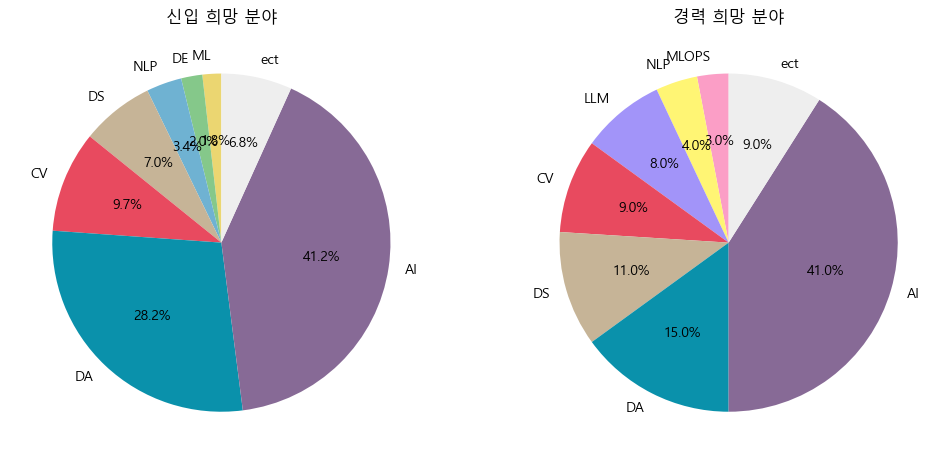

In [94]:
# 희망 데이터 분석
colors1 = ['#EBD671', '#85C88A', '#6FB2D2', '#C6B497', '#E84A5F', '#0A91AB', '#876A96', '#EEEEEE']
colors2 = ['#FB9EC6', '#FFF574', '#A294F9', '#E84A5F', '#C6B497', '#0A91AB', '#876A96', '#EEEEEE']
_ = fig, section = plt.subplots(1, 2, figsize=(12, 6))
_ = section[0].pie(desire_job_df_new_drop['level'],
                   labels=desire_job_df_new_drop.index,
                   autopct='%1.1f%%',
                   colors=colors1,
                   startangle=90)
_ = section[0].set_title('신입 희망 분야')

_ = section[1].pie(desire_job_df_pro_drop['level'],
                   labels=desire_job_df_pro_drop.index,
                   autopct='%1.1f%%',
                   colors=colors2,
                   startangle=90)
_ = section[1].set_title('경력 희망 분야')

_ = plt.show()

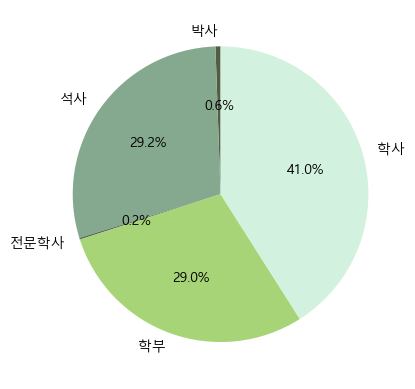

In [107]:
colors = ['#525B44', '#85A98F', '#5A6C57', '#A7D477', '#D3F1DF']
_ = plt.pie(desire_job_df['grade'].value_counts().sort_index(),
            labels=desire_job_df['grade'].value_counts().sort_index().index,
            autopct='%1.1f%%',
            colors=colors,
            startangle=90)
plt.show()